In [ ]:
# Only relevant for running in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
import pandas as pd
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Data Loading

In [ ]:
drive_path = '/content/drive/MyDrive/CS526: Data Science/Project/Raw Data' # Change this if relevant

stock_data = pd.read_csv(os.path.join(drive_path, 'stock_price_data.csv'))
congress_trades = pd.read_csv(os.path.join(drive_path, 'capitoltrades.com raw data - Sheet1.csv'))
insider_trades = pd.read_csv(os.path.join(drive_path, 'insider_trades_2020_2025.csv'))
index_fund_data = pd.read_csv(os.path.join(drive_path, 'index_funds_data.csv'))

# Data Preprocessing

## On Congressional Data

In [ ]:
# Extract name, party, level (house vs senate), and state from 'Politician'
congress_trades[['Politician name', 'party_level_state']] = congress_trades['Politician'].str.split('\n', expand=True)
split_pattern = r'([A-Z][a-z]+)([A-Z][a-z]+)([A-Z]{2})'
congress_trades[['party', 'congressional level', 'state']] = congress_trades['party_level_state'].str.extract(split_pattern)
congress_trades = congress_trades.drop(columns=['party_level_state'])

In [ ]:
# Extract Stock name, ticker, and region (to confirm only US grabbed)
congress_trades[['stock name', 'ticker_region']] = congress_trades['Traded Issuer'].str.split('\n', expand=True)
congress_trades[['stock ticker', 'region']] = congress_trades['ticker_region'].str.split(':', expand=True)
congress_trades = congress_trades.drop(columns=['ticker_region'])

In [ ]:
# Convert date like data into date objects, requires some nuanced parsing
congress_trades['Published'] = congress_trades['Published'].astype(str).str.replace('Sept', 'Sep', regex=False)
congress_trades['Traded'] = congress_trades['Traded'].astype(str).str.replace('Sept', 'Sep', regex=False)

congress_trades['Published'] = pd.to_datetime(congress_trades['Published'], errors='coerce').dt.date
congress_trades['Traded'] = pd.to_datetime(congress_trades['Traded'], errors='coerce').dt.date

congress_trades['Filed After'] = congress_trades['Filed After'].astype(str).str.extract(r'(\d+)').astype(float).astype('Int64')

In [ ]:
# Remove the dollar sign and commas from the 'Price' column and convert to float
congress_trades['Price'] = congress_trades['Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

## On Corporate insider, index fund, stock data

In [ ]:
# Convert date columns to date only format
insider_trades['trade_date'] = pd.to_datetime(insider_trades['trade_date']).dt.date
index_fund_data['Date'] = pd.to_datetime(index_fund_data['Date'], utc=True).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [ ]:
# Remove the dollar sign and commas from the 'last_price' column and convert to float
insider_trades['last_price'] = insider_trades['last_price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

# Price Difference Between Reporting and Trade Date: Congressional Politicians

In [ ]:
# Extract price and ticker from stock data
close_price_cols = [col for col in stock_data.columns if col.endswith('_close')]
melted_stock_data = pd.melt(stock_data, id_vars=['Date'], value_vars=close_price_cols, var_name='variable', value_name='Close Price')
melted_stock_data['Date'] = melted_stock_data['Date'].dt.date
melted_stock_data['stock ticker'] = melted_stock_data['variable'].str.replace('_close', '', regex=False)
melted_stock_data = melted_stock_data.drop(columns=['variable'])

In [ ]:
# Rename the 'Date' column in melted_stock_data to 'Trade Date' before merging
melted_stock_data_renamed = melted_stock_data.rename(columns={'Date': 'Trade Date'})

# Merge the congress_trades and melted_stock_data_renamed DataFrames
merged_trades_trade_price = pd.merge(
    congress_trades,
    melted_stock_data_renamed,
    left_on=['stock ticker', 'Traded'],
    right_on=['stock ticker', 'Trade Date'],
    how='left'
)

# Rename the 'Close Price' column to 'Trade Date Stock Price'
merged_trades_trade_price = merged_trades_trade_price.rename(columns={'Close Price': 'Trade Date Stock Price'})

# Drop the redundant 'Trade Date' column from melted_stock_data after merging, if it exists
if 'Trade Date_y' in merged_trades_trade_price.columns:
    merged_trades_trade_price = merged_trades_trade_price.drop(columns=['Trade Date_y'])
elif 'Trade Date' in merged_trades_trade_price.columns and 'Traded' in merged_trades_trade_price.columns and 'Trade Date' != 'Traded':
     if 'Trade Date' in melted_stock_data_renamed.columns:
         pass


In [ ]:
merged_trades_published_price = pd.merge(
    merged_trades_trade_price,
    melted_stock_data,
    left_on=['stock ticker', 'Published'],
    right_on=['stock ticker', 'Date'],
    how='left'
)
merged_trades_published_price = merged_trades_published_price.rename(columns={'Close Price': 'Published Date Stock Price'})

merged_trades_published_price = merged_trades_published_price.drop(columns=['Date'])

In [ ]:
# Calculate the difference between the stock price at the published date and the stock price at the trade date
merged_trades_published_price['Price Difference'] = merged_trades_published_price['Published Date Stock Price'] - merged_trades_published_price['Trade Date Stock Price']

# Calculate the normalized price difference
merged_trades_published_price['Normalized Price Difference'] = merged_trades_published_price['Price Difference'] / merged_trades_published_price['Trade Date Stock Price']

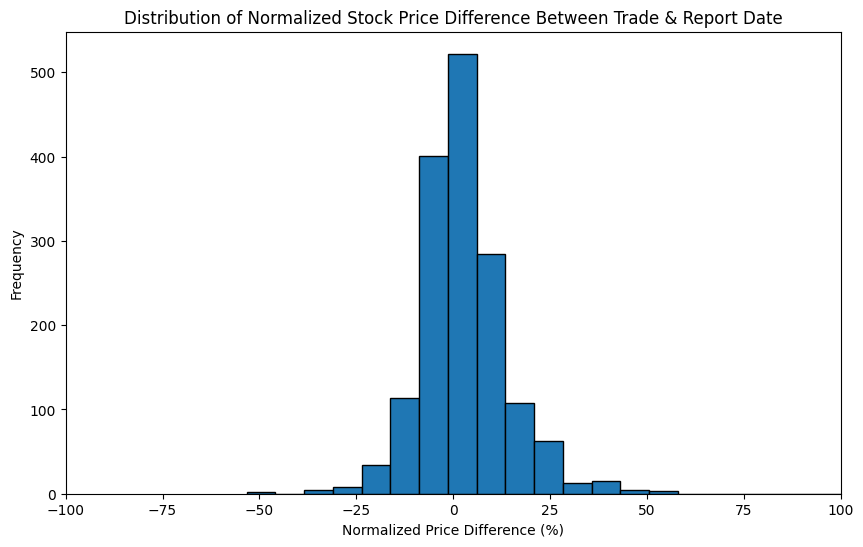


Descriptive Statistics for Normalized Price Difference:
count    1577.000000
mean        0.036034
std         0.246358
min        -0.532671
25%        -0.036868
50%         0.017809
75%         0.077418
max         6.884147
Name: Normalized Price Difference, dtype: float64


In [ ]:
# Histogram of the 'Normalized Price Difference' column
plt.figure(figsize=(10, 6))
plt.hist(merged_trades_published_price['Normalized Price Difference'].dropna()*100, bins=100, edgecolor='black')

plt.title("Distribution of Normalized Stock Price Difference Between Trade & Report Date")
plt.xlabel("Normalized Price Difference (%)")
plt.ylabel("Frequency")
plt.xlim(-100, 100)
plt.show()

# Calculate basic descriptive statistics for the 'Normalized Price Difference' column
print("\nDescriptive Statistics for Normalized Price Difference:")
print(merged_trades_published_price['Normalized Price Difference'].describe())

# Price Difference between Reporting & Transaction Date: Corporate Insider

In [ ]:
melted_stock_data_renamed = melted_stock_data.rename(columns={'Date': 'Reported Date'})

merged_insider_trades = pd.merge(
    insider_trades,
    melted_stock_data_renamed,
    left_on=['ticker', 'trade_date'],
    right_on=['stock ticker', 'Reported Date'],
    how='left'
)

merged_insider_trades = merged_insider_trades.rename(columns={'Close Price': 'Reported Date Stock Price'})
merged_insider_trades = merged_insider_trades.drop(columns=['Reported Date', 'stock ticker'])

In [ ]:
# Calculate the difference between the stock price at the reported date and the last_price
merged_insider_trades['Price Difference'] = merged_insider_trades['Reported Date Stock Price'] - merged_insider_trades['last_price']

# Normalize the price difference by dividing it by the 'last_price'
merged_insider_trades['Normalized Price Difference'] = merged_insider_trades['Price Difference'] / merged_insider_trades['last_price']

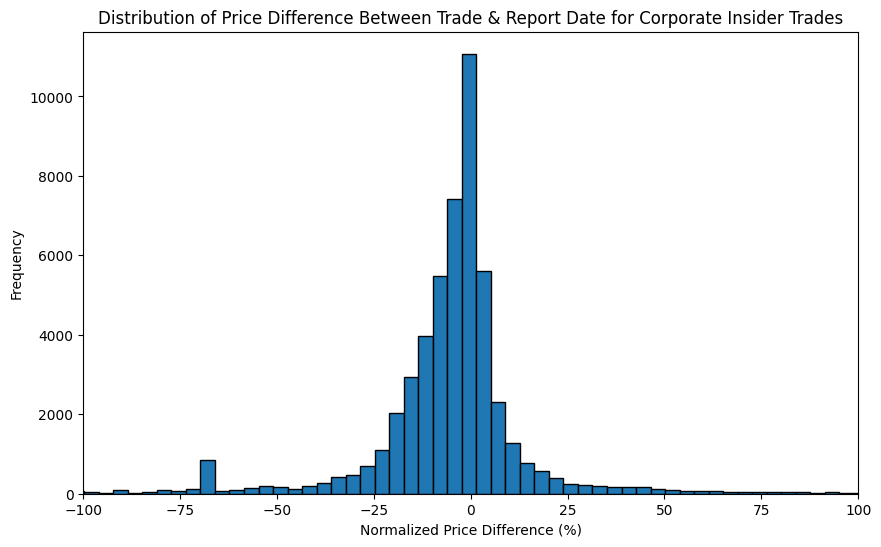


Descriptive Statistics for Price Difference (Outliers Removed):
count    55474.000000
mean         1.243584
std          6.469716
min        -87.673608
25%         -0.100794
50%         -0.020432
75%          0.032632
max         99.694444
Name: Normalized Price Difference, dtype: float64


In [ ]:
# Replace infinite values with NaN
merged_insider_trades['Normalized Price Difference'] = merged_insider_trades['Normalized Price Difference'].replace([np.inf, -np.inf], np.nan)

# Remove outliers (|Normalized Price Difference| > 100)
filtered_insider_trades = merged_insider_trades[np.abs(merged_insider_trades['Normalized Price Difference']) <= 100].copy()

# Histogram of 'Normalized Price Difference' column, dropping NaNs
plt.figure(figsize=(10, 6))
plt.hist(filtered_insider_trades['Normalized Price Difference'].dropna()*100, bins=5000, edgecolor='black')

plt.title("Distribution of Price Difference Between Trade & Report Date for Corporate Insider Trades")
plt.xlabel("Normalized Price Difference (%)")
plt.ylabel("Frequency")
plt.xlim(-100, 100)
plt.show()

print("\nDescriptive Statistics for Price Difference (Outliers Removed):")
print(filtered_insider_trades['Normalized Price Difference'].dropna().describe())

# Index Fund Baseline

In [20]:
# List of index fund tickers
index_fund_tickers = ['SPY', 'IVV', 'VOO', 'QQQ', 'VTI']

columns_to_include = ['Date'] + index_fund_tickers
filtered_index_fund_data = index_fund_data[columns_to_include].copy()
filtered_index_fund_data['Date'] = pd.to_datetime(filtered_index_fund_data['Date'])

start_date = '2020-01-01'
end_date = '2025-10-31'
filtered_index_fund_data = filtered_index_fund_data[(filtered_index_fund_data['Date'] >= start_date) & (filtered_index_fund_data['Date'] <= end_date)].copy()


In [21]:
# Define the time periods for analysis and their corresponding number of months
time_periods = {
    '1 Month': 1,
    '2 Months': 2,
    '3 Months': 3,
    '6 Months': 6,
    '1 Year': 12,
    '2 Years': 24
}

In [22]:
for period_name, months in time_periods.items():
    for ticker in index_fund_tickers:
        new_col_name = f'{ticker}_{period_name}_pct_change'
        filtered_index_fund_data[new_col_name] = filtered_index_fund_data[ticker].pct_change(periods=months)

In [23]:
index_fund_performance = {}

for period_name, months in time_periods.items():
    for ticker in index_fund_tickers:
        pct_change_col = f'{ticker}_{period_name}_pct_change'
        data = filtered_index_fund_data[pct_change_col].dropna()
        if len(data) > 1:
            # Calculate mean
            mean_pct_change = data.mean()
            # Calculate standard error of the mean
            sem = stats.sem(data)
            # Calculate the 95% confidence interval
            df = len(data) - 1
            confidence_interval = stats.t.interval(0.95, df, loc=mean_pct_change, scale=sem)

            index_fund_performance[pct_change_col] = {
                'mean': mean_pct_change,
                'confidence_interval': confidence_interval
            }
        else:
            index_fund_performance[pct_change_col] = {
                'mean': None,
                'confidence_interval': None
            }

print("Average Percentage Change and 95% Confidence Interval for Index Funds (Jan 2020 - Oct 2025):")
for fund_period, performance in index_fund_performance.items():
    print(f"{fund_period}:")
    if performance['mean'] is not None:
        print(f"  Mean: {performance['mean']:.4f}")
        print(f"  95% Confidence Interval: ({performance['confidence_interval'][0]:.4f}, {performance['confidence_interval'][1]:.4f})\n")
    else:
        print(f"  Not enough data to calculate mean and confidence interval.\n")

Average Percentage Change and 95% Confidence Interval for Index Funds (Jan 2020 - Oct 2025):
SPY_1 Month_pct_change:
  Mean: 0.0131
  95% Confidence Interval: (0.0008, 0.0254)

IVV_1 Month_pct_change:
  Mean: 0.0132
  95% Confidence Interval: (0.0008, 0.0255)

VOO_1 Month_pct_change:
  Mean: 0.0131
  95% Confidence Interval: (0.0008, 0.0255)

QQQ_1 Month_pct_change:
  Mean: 0.0171
  95% Confidence Interval: (0.0026, 0.0317)

VTI_1 Month_pct_change:
  Mean: 0.0127
  95% Confidence Interval: (0.0000, 0.0254)

SPY_2 Months_pct_change:
  Mean: 0.0276
  95% Confidence Interval: (0.0112, 0.0440)

IVV_2 Months_pct_change:
  Mean: 0.0278
  95% Confidence Interval: (0.0114, 0.0442)

VOO_2 Months_pct_change:
  Mean: 0.0277
  95% Confidence Interval: (0.0113, 0.0441)

QQQ_2 Months_pct_change:
  Mean: 0.0356
  95% Confidence Interval: (0.0152, 0.0561)

VTI_2 Months_pct_change:
  Mean: 0.0269
  95% Confidence Interval: (0.0098, 0.0440)

SPY_3 Months_pct_change:
  Mean: 0.0436
  95% Confidence Inter

In [24]:
data_for_df = []

for fund_period, performance in index_fund_performance.items():
    parts = fund_period.split('_')
    ticker = parts[0]
    time_period = ' '.join(parts[1:-2])


    # Check if mean and confidence interval are not None
    if performance['mean'] is not None:
        mean_change = performance['mean']
        lower_bound = performance['confidence_interval'][0]
        upper_bound = performance['confidence_interval'][1]

        data_for_df.append({
            'Time Period': time_period,
            'Index Fund': ticker,
            'Mean Percentage Change': mean_change,
            'Lower Bound CI': lower_bound,
            'Upper Bound CI': upper_bound
        })
    else:
        data_for_df.append({
            'Time Period': time_period,
            'Index Fund': ticker,
            'Mean Percentage Change': None,
            'Lower Bound CI': None,
            'Upper Bound CI': None
        })

performance_df = pd.DataFrame(data_for_df)

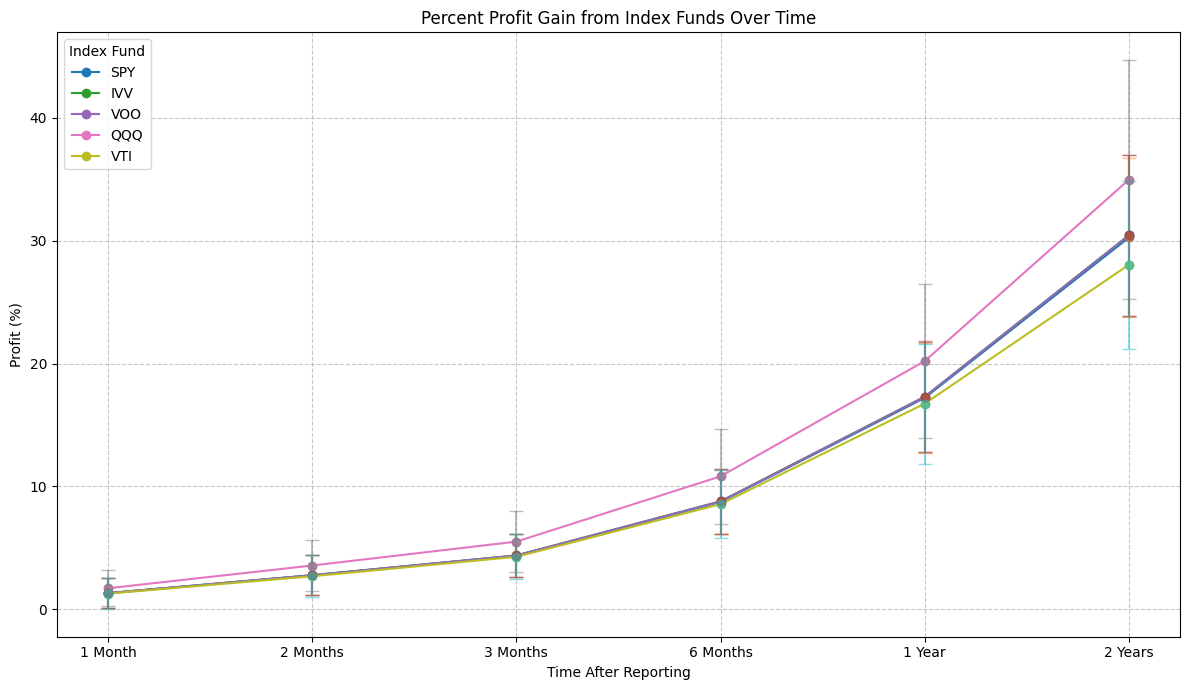

In [25]:
time_period_order = ['1 Month', '2 Months', '3 Months', '6 Months', '1 Year', '2 Years']
performance_df['Time Period'] = pd.Categorical(performance_df['Time Period'], categories=time_period_order, ordered=True)

performance_df = performance_df.sort_values(by='Time Period')

plt.figure(figsize=(12, 7))

for fund in performance_df['Index Fund'].unique():
    fund_data = performance_df[performance_df['Index Fund'] == fund].dropna()
    # Multiply percentage change and confidence intervals by 100 for percentage display
    plt.plot(fund_data['Time Period'], fund_data['Mean Percentage Change'] * 100, marker='o', label=fund)
    plt.errorbar(fund_data['Time Period'], fund_data['Mean Percentage Change'] * 100,
                 yerr=[(fund_data['Mean Percentage Change'] - fund_data['Lower Bound CI']) * 100,
                       (fund_data['Upper Bound CI'] - fund_data['Mean Percentage Change']) * 100],
                 fmt='o', capsize=5, alpha=0.5)

plt.title("Percent Profit Gain from Index Funds Over Time")
plt.xlabel("Time After Reporting")
plt.ylabel("Profit (%)")

plt.legend(title="Index Fund")
plt.grid(True, linestyle='--',alpha=0.7)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()